Evaluating Random Forest...
Accuracy: 0.9975, Precision: 0.9977, Recall: 0.9975, F1 Score: 0.9975
Cross-Validation Accuracy: 0.8942 (+/- 0.0810)
Evaluating KNN...
Accuracy: 0.9140, Precision: 0.9166, Recall: 0.9140, F1 Score: 0.9134
Cross-Validation Accuracy: 0.8304 (+/- 0.0467)
Evaluating SVM...
Accuracy: 0.9140, Precision: 0.9166, Recall: 0.9140, F1 Score: 0.9097
Cross-Validation Accuracy: 0.8452 (+/- 0.0742)
Evaluating Logistic Regression...
Accuracy: 0.9656, Precision: 0.9657, Recall: 0.9656, F1 Score: 0.9655
Cross-Validation Accuracy: 0.8427 (+/- 0.0290)

Best Model: Random Forest

Best Hyperparameters for Random Forest :
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Model saved to /content/Random Forest_best_model.pkl

Model Comparison:
                      accuracy precision    recall        f1   cv_mean  \
Random Forest        0.997543   0.99766  0.997543  0.997543  0.894249   
KNN                  0.914005  0.916643  0.914005  0.913366 

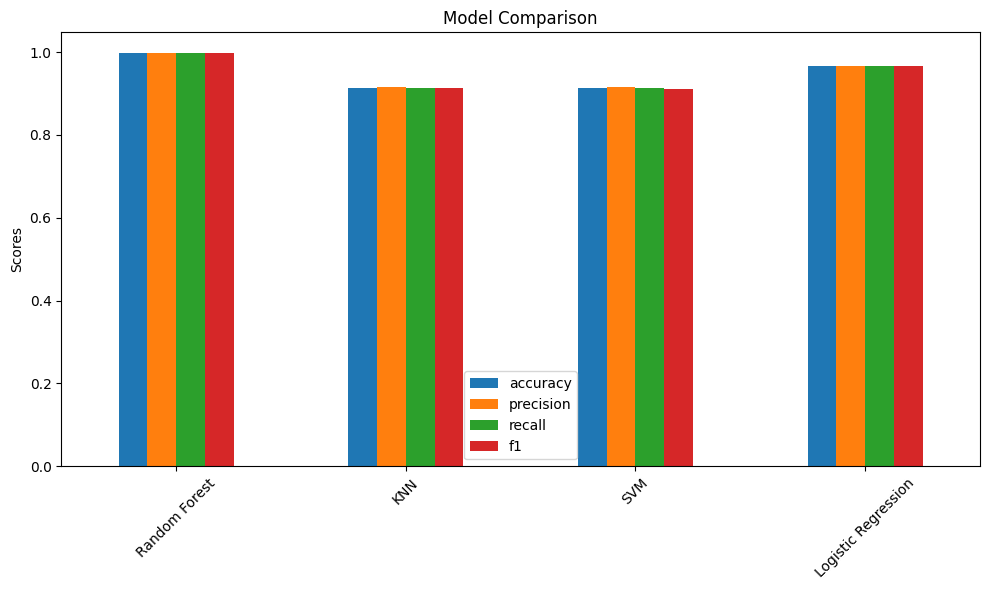

Model saved to /content/best_model.pkl


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Assuming your data is loaded into 'data' DataFrame
data = pd.read_csv('/content/SSL.csv')  # Replace with actual path

# Preprocessing (drop missing values, etc.)
X = data.drop(columns='LABEL')  # Assuming 'LABEL' is your label column
y = data['LABEL']

# Function to evaluate models
def evaluate_model(model, X, y):
    # Cross-validation (5-fold)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    model.fit(X, y)

    # Prediction and evaluation metrics
    y_pred = model.predict(X)

    # Modify for multiclass classification
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')  # Change here
    recall = recall_score(y, y_pred, average='weighted')  # Change here
    f1 = f1_score(y, y_pred, average='weighted')  # Change here

    # Output evaluation metrics
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print(f'Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})')

    return model, accuracy, precision, recall, f1, cv_scores


# Hyperparameter tuning for the best model
def hyperparameter_tuning(X, y, best_model_name):
    # Define the best model based on the model name
    if best_model_name == 'Random Forest':
        best_model = RandomForestClassifier(random_state=42)
        tuning_params = {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif best_model_name == 'KNN':
        best_model = KNeighborsClassifier()
        tuning_params = {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    elif best_model_name == 'SVM':
        best_model = SVC(random_state=42, probability=True)
        tuning_params = {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    elif best_model_name == 'Logistic Regression':
        best_model = LogisticRegression(random_state=42)
        tuning_params = {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'saga']
        }
    else:
        raise ValueError(f"Unknown model: {best_model_name}")

    # Apply grid search for hyperparameter tuning
    grid_search = GridSearchCV(estimator=best_model, param_grid=tuning_params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)

    # Output the best hyperparameters
    print("\nBest Hyperparameters for", best_model_name, ":")
    print(grid_search.best_params_)

    return grid_search.best_estimator_


# Function to save the model
def save_model(model, model_filename):
    joblib.dump(model, model_filename)
    print(f"Model saved to {model_filename}")


# Evaluate multiple models and choose the best
def evaluate_multiple_models(X, y):
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42)
    }

    results = {}
    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        model, accuracy, precision, recall, f1, cv_scores = evaluate_model(model, X, y)
        results[model_name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std()
        }

    # Choose the best model based on highest accuracy
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])
    print(f"\nBest Model: {best_model_name}")

    # Hyperparameter tuning for the best model
    best_model = hyperparameter_tuning(X, y, best_model_name)

    # Save the best model
    save_model(best_model, f'/content/{best_model_name}_best_model.pkl')

    return results, best_model


# Train, evaluate, and save the best model
results, best_model = evaluate_multiple_models(X, y)

# Visualizing the results of the models
results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1', 'cv_mean', 'cv_std']]

# Print the model comparison
print("\nModel Comparison:\n", results_df)

# Plotting the results
plt.figure(figsize=(10, 6))
results_df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', ax=plt.gca())
plt.title('Model Comparison')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optionally save and load the best model again
save_model(best_model, '/content/best_model.pkl')  # Save the best model

# Load the best model (if needed)
loaded_model = joblib.load('/content/best_model.pkl')  # Load the model to show the results


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import joblib

# Assuming your data is loaded into 'data' DataFrame
data = pd.read_csv('/content/SSL.csv')  # Replace with actual path

X = data.drop(columns='LABEL')  # Assuming 'LABEL' is your label column
y = data['LABEL']

# Function to evaluate models
def evaluate_model(model, X, y):
    # Cross-validation (5-fold)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    model.fit(X, y)

    # Prediction and evaluation metrics
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    # Output evaluation metrics
    return accuracy, precision, recall, f1, cv_scores.mean(), cm

# Hyperparameter tuning for the best model
def hyperparameter_tuning(X, y, best_model_name):
    if best_model_name == 'Random Forest':
        best_model = RandomForestClassifier(random_state=42)
        tuning_params = {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif best_model_name == 'KNN':
        best_model = KNeighborsClassifier()
        tuning_params = {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    elif best_model_name == 'SVM':
        best_model = SVC(random_state=42)
        tuning_params = {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    elif best_model_name == 'Logistic Regression':
        best_model = LogisticRegression(random_state=42)
        tuning_params = {
            'C': [0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'saga']
        }
    else:
        raise ValueError(f"Unknown model: {best_model_name}")

    # Apply grid search for hyperparameter tuning
    grid_search = GridSearchCV(estimator=best_model, param_grid=tuning_params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X, y)

    # Hyperparameter Tuning Accuracy
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X)
    hyperparameter_tuning_accuracy = accuracy_score(y, y_pred)

    return hyperparameter_tuning_accuracy, grid_search.best_params_

# Evaluate multiple models and choose the best
def evaluate_multiple_models(X, y):
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42)
    }

    results = {}
    for model_name, model in models.items():
        accuracy, precision, recall, f1, cv_mean, cm = evaluate_model(model, X, y)
        results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'cv_mean': cv_mean,
            'confusion_matrix': cm
        }

    # Choose the best model based on highest accuracy
    best_model_name = max(results, key=lambda x: results[x]['accuracy'])

    # Hyperparameter tuning for the best model
    hyperparameter_tuning_accuracy, best_params = hyperparameter_tuning(X, y, best_model_name)

    # Output all metrics for the best model
    best_model_metrics = results[best_model_name]
    print(f"\nBest Model: {best_model_name}")
    print(f"Cross-Validation Accuracy: {best_model_metrics['cv_mean']:.4f}")
    print(f"Precision: {best_model_metrics['precision']:.4f}")
    print(f"Recall: {best_model_metrics['recall']:.4f}")
    print(f"F1-Score: {best_model_metrics['f1']:.4f}")
    print(f"Confusion Matrix:\n{best_model_metrics['confusion_matrix']}")
    print(f"Hyperparameter Tuning Accuracy: {hyperparameter_tuning_accuracy:.4f}")
    print(f"Best Hyperparameters: {best_params}")

# Run the evaluation and hyperparameter tuning
evaluate_multiple_models(X, y)



Best Model: Random Forest
Cross-Validation Accuracy: 0.8942
Precision: 0.9977
Recall: 0.9975
F1-Score: 0.9975
Confusion Matrix:
[[22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 29  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 23  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 24  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0]
 [ 0  0  0  0  0